In [5]:
from datasets import load_dataset, Features, Value

# Define the expected schema explicitly
features = Features({
    'YoutubeID': Value('string'),
    'audio': Value('string'),
    'visual': Value('string'),
    'speech': Value('string'),
    'av_caption': Value('string'),
    'avs': Value('string'),
    'fps': Value('float64'),
    'start_frame': Value('int64'),
    'end_frame': Value('int64')
})

# Load the dataset with defined features
dataset_full = load_dataset("OpenGVLab/InternVideo2_Vid_Text", features=features)


Found cached dataset json (/Users/zhuzengliang/.cache/huggingface/datasets/OpenGVLab___json/OpenGVLab--InternVideo2_Vid_Text-9937fffaa45d0f51/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dataset_full.keys()

dict_keys(['train'])

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import random

# Define the size of the sample
sample_size = 10000  # Adjust this based on the size of the dataset

# Get the total number of rows in the dataset
total_size = len(dataset_full['train'])
print(total_size)
# Randomly select indices for the sample
random_indices = random.sample(range(total_size), sample_size)

# Create a subset of the dataset using the selected indices
dataset = dataset_full['train'].select(random_indices)


123519338


Q1: 4.0, Median: 4.0, Q3: 47.0


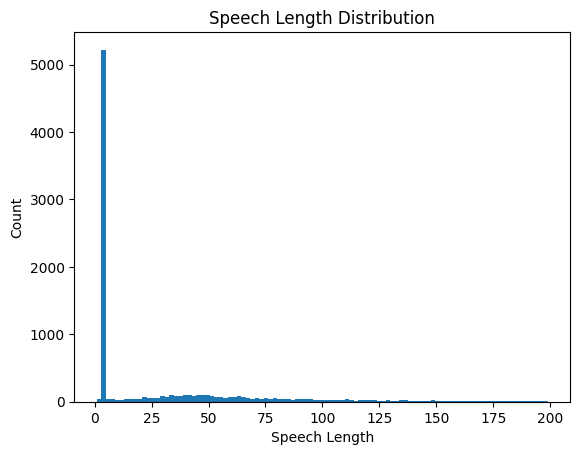

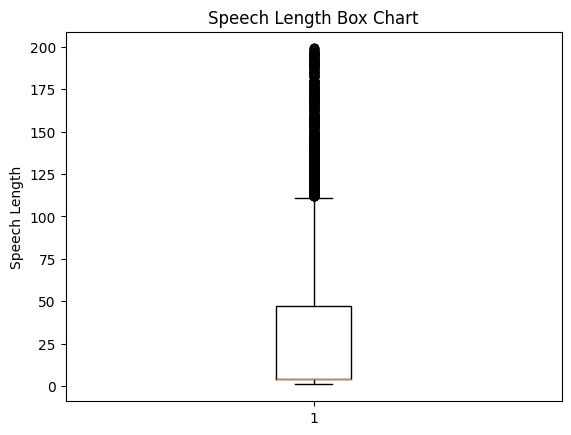

In [12]:

speech_len = dataset['speech']
speech_len = [len(str(s)) for s in speech_len]

# Convert to numpy array for processing
speech_len = np.array(speech_len)

# Filter: Remove speech length > 200 and <= 0
filtered_speech_len = speech_len[(speech_len < 200) & (speech_len > 0)]

# Calculate statistics
mean = np.mean(filtered_speech_len)
median = np.median(filtered_speech_len)
max_len = np.max(filtered_speech_len)
min_len = np.min(filtered_speech_len)
std = np.std(filtered_speech_len)



# Calculate IQR
Q1 = np.percentile(filtered_speech_len, 25)
Q3 = np.percentile(filtered_speech_len, 75)
IQR = Q3 - Q1

print(f"Q1: {Q1}, Median: {median}, Q3: {Q3}")

# Plot histogram
plt.hist(filtered_speech_len, bins=100)
plt.xlabel('Speech Length')
plt.ylabel('Count')
plt.title('Speech Length Distribution')
plt.show()

# Plot box chart
plt.boxplot(filtered_speech_len)
plt.ylabel('Speech Length')
plt.title('Speech Length Box Chart')
plt.show()


In [22]:
subtitle_none = []
subtitle_short_long = []


for entry in dataset:
    if entry['speech'] == None:
        subtitle_none.append(entry)
    else:
        subtitle_short_long.append(entry)


In [23]:
len(subtitle_none)

5133

In [24]:
len(subtitle_short_long)

4867

In [37]:
import random

# construct a sample dataset with haf of subtitle_none and subtitle_not_none
random.seed(0)
subtitle_none_sample = random.sample(subtitle_none, 20)
subtitle_short_sample = random.sample(subtitle_short_long, 100)

internVid_sample_test_120 = subtitle_none_sample + subtitle_short_sample 

In [38]:
import json 
with open('intern_vid_test120.json', 'w') as file:
    json.dump(internVid_sample_test_120, file, indent=4)

In [27]:
!pip install yt_dlp

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
spyder 5.4.1 requires pyqt5<5.16, which is not installed.
spyder 5.4.1 requires pyqtwebengine<5.16, which is not installed.
google-api-core 2.14.0 requires google-auth<3.0.dev0,>=2.14.1, but you have google-auth 1.35.0 which is incompatible.
google-api-core 2.14.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
optimum 1.13.2 requires transformers[sentenc

In [39]:
import json
import os
import sys
import yt_dlp
import subprocess

def check_and_download(youtube_id, start_frame, end_frame, fps, output_dir, cookie_file=None):
    # Calculate start and end times in seconds
    start_time = start_frame / fps
    end_time = end_frame / fps
    video_id = youtube_id

    # Check if the trimmed video already exists
    if os.path.exists(f'{output_dir}/{video_id}.mp4'):
        print(f'Video clip {video_id} already exists.')
        return True

    youtube_url = f'https://www.youtube.com/watch?v={youtube_id}'
    
    if cookie_file:
        ydl_opts = {
            'format': 'mp4',  
            'outtmpl': f'{output_dir}/{youtube_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  
            }],
            'cookiefile': cookie_file
        }
    else:
        ydl_opts = {
            'format': 'mp4',  
            'outtmpl': f'{output_dir}/{youtube_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  
            }]
        }

    try:
        # Download the video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])
        
        if not os.path.exists(f'{output_dir}/{youtube_id}_og.mp4'):
            print(f'Video {video_id} is not mp4')
            return False
        
        input_file = f'{output_dir}/{youtube_id}_og.mp4'
        output_file = f'{output_dir}/{video_id}.mp4'
        duration = end_time - start_time

        # Trim the video using ffmpeg
        subprocess.run([
            'ffmpeg', '-ss', str(start_time), '-i', input_file, '-t', str(duration), '-c', 'copy', output_file
        ], check=True)

        print(f'Video {output_file} downloaded and trimmed successfully.')
        os.remove(input_file) # delete the original video, only keep the trimmed one
        return True
    except Exception as e:
        print(f'Video {video_id} fails downloading: {e}')
        return False

def main(json_file, output_dir, cookie_file=None):
    with open(json_file) as file:
        sample_data = json.load(file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print('>>>>> Start downloading video clips <<<<<')
    for video in sample_data:
        check_and_download(
            video['YoutubeID'], 
            video['start_frame'], 
            video['end_frame'], 
            video['fps'], 
            output_dir, 
            cookie_file
        )
    print('>>>>> Finish downloading video clips <<<<<')

        



In [ ]:

json_file = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/internVid2/intern_vid_test120.json"
output_dir = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/internVid2/raw_video"
cookie_file = "/Users/zhuzengliang/Downloads/www.youtube.com_cookies.txt"

main(json_file, output_dir, cookie_file)

## VAST dataset

In [6]:
!pip install ijson



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import ijson
import random
random.seed = 1
file_path = '/Users/zhuzengliang/Downloads/annotations.json'
sample_size = 10000
reservoir = []

# Open the large JSON file for incremental reading
with open(file_path, 'r') as f:
    parser = ijson.items(f, 'item')  # 'item' works if your JSON is an array of objects

    for index, item in enumerate(parser):
        if index < sample_size:
            # Initially fill the reservoir with the first 'sample_size' elements
            reservoir.append(item)
        else:
            # Randomly replace elements in the reservoir with decreasing probability
            r = random.randint(0, index)
            if r < sample_size:
                reservoir[r] = item

# The 'reservoir' now contains a uniform random sample of 'sample_size' items
print(reservoir[:5])  # Print first 5 items from the sample to verify


[{'clip_id': 'XLUdr4CeD5k.8', 'clip_span': ['00:01:42.979', '00:02:02.820'], 'url': 'https://www.youtube.com/watch?v=XLUdr4CeD5k', 'vision_cap': ['a white mascara walks down a street, then turns, and drives.', 'a car drives down a street at high rate of speed.', 'a white suv is driving down a street in a residential area.', 'a person drives a white car down a street, and turns and drives forward, then turns around and turns.', 'a person is talking while a white car is going down a road'], 'audio_cap': ['music is playing.', 'dj is explaining their upcoming tracks.', 'a loop is being recorded.', 'music is being played on a musical instrument.', 'a loop is being recorded.'], 'subtitle': 'The engine responds quite well. In fact, if we are calm driving in the city, we could only occupy the electric motor most of the time, especially if we are in transit when we need more power between the gasoline engine and with the help of the box leave six speeds is that we get a handling that leaves us 

Mean: 116.34922010398614, Median: 115.0, Max Length: 199, Min Length: 19, Std: 41.6495236915078
Q1: 83.0, Median: 115.0, Q3: 148.75


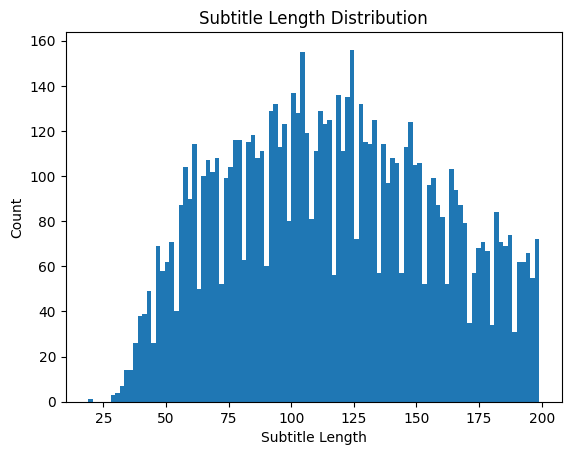

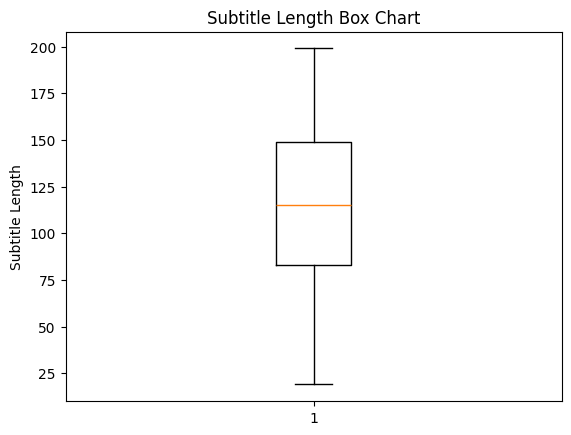

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `reservoir` contains the sampled data
# Extract the 'subtitle' field from each item in the sample
subtitle_len = [len(item['subtitle']) for item in reservoir if item['subtitle']]

# Convert to numpy array for processing
subtitle_len = np.array(subtitle_len)

# Filter: Remove subtitle length > 200 and <= 0
filtered_subtitle_len = subtitle_len[(subtitle_len < 200) & (subtitle_len > 0)]

# Calculate statistics
mean = np.mean(filtered_subtitle_len)
median = np.median(filtered_subtitle_len)
max_len = np.max(filtered_subtitle_len)
min_len = np.min(filtered_subtitle_len)
std = np.std(filtered_subtitle_len)

# Calculate IQR
Q1 = np.percentile(filtered_subtitle_len, 25)
Q3 = np.percentile(filtered_subtitle_len, 75)
IQR = Q3 - Q1

print(f"Mean: {mean}, Median: {median}, Max Length: {max_len}, Min Length: {min_len}, Std: {std}")
print(f"Q1: {Q1}, Median: {median}, Q3: {Q3}")

# Plot histogram
plt.hist(filtered_subtitle_len, bins=100)
plt.xlabel('Subtitle Length')
plt.ylabel('Count')
plt.title('Subtitle Length Distribution')
plt.show()

# Plot box chart
plt.boxplot(filtered_subtitle_len)
plt.ylabel('Subtitle Length')
plt.title('Subtitle Length Box Chart')
plt.show()


In [4]:
subtitle_none = []
subtitle_short_long = []

for entry in reservoir:
    # Check if the length of the 'speech' is less than 25
    if len(entry['subtitle']) < 25:
        subtitle_none.append(entry)
    else:
        subtitle_short_long.append(entry)


In [5]:
subtitle_none

[{'clip_id': 'k5HBLuM8Mdg.14',
  'clip_span': ['00:00:50.050', '00:00:56.051'],
  'url': 'https://www.youtube.com/watch?v=k5HBLuM8Mdg',
  'vision_cap': ["a man and woman are holding the teacher's box program as a screen shows a video of it.",
   'a woman is talking about a video of people that are being train.',
   'a woman and a man are shown smiling in front of a screen then an news cast appears on the screen.',
   'a news anchor gives a video of a new teacher.',
   'a news report about a teacher that is teaching.'],
  'audio_cap': ['voice over request.',
   'an announcement is being made.',
   'voice is over.',
   'freesound project is being described.',
   'someone is announcing a safety announcement.'],
  'subtitle': "&gt;&gt; IT'S HUGE.",
  'vast_cap': "A news report about a teacher teaching is being described, and it's huge."}]

In [ ]:
# The result shows that all videos has human voice (because subtitle is not short)

In [2]:

# Randomly sample 120 items from the reservoir
sampled_items = random.sample(reservoir, 3000)

# Print the first few sampled items to verify
print(sampled_items[:5])


[{'clip_id': 'QshYIIgg87I.6', 'clip_span': ['00:00:52.500', '00:01:05.850'], 'url': 'https://www.youtube.com/watch?v=QshYIIgg87I', 'vision_cap': ['a foreign news reporter is being interviewed by a female reporter.', 'a man with a microphone stands in front of a white building and speaks into a camera.', 'the news anchor is talking into a microphone.', 'a man is being interviewed in spanish with a microphone.', 'a male reporter is talking about a foreign country as someone starts to be interviewed.'], 'audio_cap': ['someone is giving an explanation to a microphone.', 'someone is telling the microphone about their life.', 'someone is giving an explanation to a microphone.', 'the man is describing a project.', 'someone is giving an explanation to a microphone.'], 'subtitle': 'No no does not do anything by the community, since they were asked to our Lord Mayor that an invitation from All the presidents who belong to the clear water side are making that great invitation.', 'vast_cap': 'A ma

In [9]:
import random

# Randomly sample 120 items from the reservoir
sampled_items2 = random.sample(sampled_items, 60)

# Print the first few sampled items to verify
print(sampled_items2[:5])

[{'clip_id': 'G51jyOgd6qc.5', 'clip_span': ['00:00:48.989', '00:00:56.039'], 'url': 'https://www.youtube.com/watch?v=G51jyOgd6qc', 'vision_cap': ['a man interviewing a player', 'a man is having a conversation', 'a man speaks to a press group and talks about soccer', 'a man is talking', 'the men were talking'], 'audio_cap': ['a man is talking about the price of the product.', 'people are talking at a library.', 'a man is talking about the price of the product.', 'a man is talking about the price of the product.', 'people are talking in a library.'], 'subtitle': 'The next game happens to be Shirley and its another three points on our phone. What will you demand from your players on Saturday against decide who are in the relegation zone?', 'vast_cap': 'A man is talking about the price of a product while having a conversation, and he is also asking about the demand for the players on Saturday against a team named Shirley, who are in the relegation zone.'}, {'clip_id': '8SmaUm6xOF4.41', 'cl

In [10]:
import json 
with open('vast_test60.json', 'w') as file:
    json.dump(sampled_items, file, indent=4)

In [ ]:
#download vast
import json
import os
import sys
import yt_dlp
import subprocess

def check_and_download(clip_id, clip_span, url, output_dir, cookie_file=None):
    # Parse the clip_span to get start and end times
    start_time_str, end_time_str = clip_span
    start_time = convert_time_to_seconds(start_time_str)
    end_time = convert_time_to_seconds(end_time_str)
    duration = end_time - start_time

    video_id = clip_id.split('.')[0]  # Extract YouTube ID from clip_id

    # Check if the trimmed video already exists
    if os.path.exists(f'{output_dir}/{clip_id}.mp4'):
        print(f'Video clip {clip_id} already exists.')
        return True

    youtube_url = url

    # Set up yt_dlp options
    if cookie_file:
        ydl_opts = {
            'format': 'mp4',
            'outtmpl': f'{output_dir}/{video_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',
            }],
            'cookiefile': cookie_file
        }
    else:
        ydl_opts = {
            'format': 'mp4',
            'outtmpl': f'{output_dir}/{video_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',
            }]
        }

    try:
        # Download the video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])

        if not os.path.exists(f'{output_dir}/{video_id}_og.mp4'):
            print(f'Video {clip_id} is not mp4')
            return False

        input_file = f'{output_dir}/{video_id}_og.mp4'
        output_file = f'{output_dir}/{clip_id}.mp4'

        # Trim the video using ffmpeg
        subprocess.run([
            'ffmpeg', '-ss', str(start_time), '-i', input_file, '-t', str(duration), '-c', 'copy', output_file
        ], check=True)

        print(f'Video {output_file} downloaded and trimmed successfully.')
        os.remove(input_file)  # delete the original video, only keep the trimmed one
        return True
    except Exception as e:
        print(f'Video {clip_id} fails downloading: {e}')
        return False

def convert_time_to_seconds(time_str):
    """Convert a time string (hh:mm:ss.xxx) to seconds."""
    hours, minutes, seconds = time_str.split(':')
    return int(hours) * 3600 + int(minutes) * 60 + float(seconds)

def main(json_file, output_dir, cookie_file=None):
    with open(json_file) as file:
        sample_data = json.load(file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print('>>>>> Start downloading video clips <<<<<')
    for video in sample_data:
        check_and_download(
            video['clip_id'], 
            video['clip_span'], 
            video['url'], 
            output_dir, 
            cookie_file
        )
    print('>>>>> Finish downloading video clips <<<<<')




json_file = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/vast/vast_test120.json"
output_dir = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/vast/raw_video"
cookie_file = "/Users/zhuzengliang/Downloads/www.youtube.com_cookies.txt"

main(json_file, output_dir, cookie_file)

In [11]:
import json

# Define the path to your JSON file
input_json_file = "/Users/zhuzengliang/Documents/GitHub/VividScribe/output/mix120_groundtruth.json"

# Initialize an empty set to store video ids
video_ids = set()

# Read the JSON file
with open(input_json_file, 'r') as f:
    data = json.load(f)

# Iterate through the annotations and add each video_id to the set
for annotation in data["annotations"]:
    video_ids.add(annotation["video_id"])

# Print the set of video ids
print(video_ids)


{'LrL3EbvtOVw.40', 'rzHXGinD6ZE_20.000_30.000', '4KeFV0rAu_0_14.000_24.000', 'wllkJ2lazaI.4', '1lfmwRJYins.9', 'INNIheBpNKY.22', 'Jy04Fe2rNmw.2', 'R7ls6ZQJ5UM_570.000_580.000', 'UmWkmGAu5Hc.14', '-rr68KmhIzc.20', '1c7NBk1x3y0_30.000_40.000', 'mNsYlojC_kM_230.000_240.000', 'NAIQyoPcjNM.11', 'W7gn2todzbg_30.000_40.000', 'fWwV7o4VjEQ_30.000_40.000', 'uLWBKxHSwyY.36', '2xmCKjpuSfQ.24', 'brRabaaeoy4.36', 'z3xiKSDoZEI_160.000_170.000', 's8UnuTvElzQ_0.000_10.000', 'g7sVjiG-ytg_110.000_120.000', 'UbpTXBNIXtQ.18', 'e3BdNhbiDwA_230.000_240.000', 'CgTc_-A_Gzw_0.000_8.000', 'GfoyjUOE9Ek.8', 'Bltc4o615qI.43', 'NYl0fGcNVl0.6', 'Olrb-mdHJ7s_150.000_160.000', 'AU1l1i0H0j0_30.000_40.000', 'evy2azZk3kE_40.000_50.000', 'LOVcimphxEc.1', 'TiFboW8mqd4_30.000_40.000', 'prmGPzSpZtg.20', 'p63sYVCLVUk_30.000_40.000', 'aAzt7VFvhH0.5', 'clJZQsQzGCA_490.000_500.000', 'piYDsIrSvME.27', 'ZHSPLH5-zvw_50.000_60.000', 'ZX7EzqMBjfo_160.000_170.000', 'eRiuGf1nzM0.3', '96VZFklUM_Q.32', 'aoRW7iWXwoM.31', '2gc1L3g1itU_20.00

In [12]:
with open("/Users/zhuzengliang/Documents/GitHub/VividScribe/VALOR/output/valor_120_output.json", 'r') as f:
    valor_data = json.load(f)

In [22]:
result = []
for row in valor_data:
    if row["clip_id"] in video_ids:
        result.append({
           "video_id": row["clip_id"],
           "caption": row["generated_caption"][0]
       })

In [23]:
result[0]

{'video_id': 'hJYU3nBSyFo_10.000_20.000',
 'caption': 'a red car pulled up on the side of the road making a buzz'}

In [24]:
with open("/Users/zhuzengliang/Documents/GitHub/VividScribe/VALOR/output/vast_60_output.json", 'r') as f:
    vast_data = json.load(f)


In [25]:
for row in vast_data:
    if row["clip_id"] in video_ids:
        result.append({
           "video_id": row["clip_id"],
           "caption": row["generated_caption"][0]
       })

In [26]:
import json 
with open('competitive_valor.json', 'w') as file:
    json.dump({"annotations":result}, file, indent=4)

In [3]:
import os
audios_dir = os.listdir("/Users/zhuzengliang/Downloads/extracted_data/audio_22050hz")

In [4]:
audios_dir[0]

'96VZFklUM_Q.32.wav'

In [9]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
import torchaudio
import torch
import os
import json
from tqdm import tqdm

# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to("mps")
model.config.forced_decoder_ids = None

# Root directory and audio files list
root = "/Users/zhuzengliang/Downloads/extracted_data/audio_22050hz"
audios_dir = os.listdir(root)  # List of all files in the directory
audios_dir = [file for file in audios_dir if file.endswith(".wav")]  # Filter only .wav files

# Initialize list to store results
results = []

# Process each .wav file and transcribe
for audio_file in tqdm(audios_dir, desc="Processing audio files"):
    wav_file_path = os.path.join(root, audio_file)

    # Load audio using torchaudio
    waveform, original_sampling_rate = torchaudio.load(wav_file_path)

    # Resample to 16000 Hz if necessary
    target_sampling_rate = 16000
    if original_sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sampling_rate, new_freq=target_sampling_rate)
        waveform = resampler(waveform)

    # Convert to mono if multiple channels
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)

    # Convert to input features using the processor
    input_features = processor(waveform.squeeze().numpy(), sampling_rate=target_sampling_rate, return_tensors="pt").input_features.to("mps")

    # Generate token ids
    with torch.no_grad():
        predicted_ids = model.generate(input_features)

    # Decode token ids to text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Save result
    result = {
        "filename": audio_file.replace(".wav", ""),
        "transcript": transcription
    }
    results.append(result)

# Save all results to a JSON file
output_json_file = 'transcriptions.json'
with open(output_json_file, 'w') as outfile:
    json.dump(results, outfile, indent=4)

print(f"Transcriptions saved to {output_json_file}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Processing audio files: 100%|██████████| 117/117 [06:02<00:00,  3.10s/it]

Transcriptions saved to transcriptions.json


In [8]:
transcription

[' just a whole food type of diet which is like this primal paleo-esque type of diet where I just you know eat real good clean food.']

In [2]:
api_key = input("openai_key")

In [ ]:
prompt1 =  f"""Given the caption: "{caption}" and the transcript: "{transcript}", create an enriched version of the caption. Ensure that the enriched caption remains consistent with both the caption and the transcript. Be careful with the transcript as it may contain inaccuracies, and only use the parts that are coherent. Do not introduce new information not found in the caption or transcript."""

In [1]:
prompt2 = f"""Given the caption: "{caption}" and the transcript: "{transcript}", generate an enriched version of the caption by integrating relevant information from both inputs. Assume the caption was written by someone who can see and hear but does not understand the language, while the transcript was created by someone who cannot see but can speak the language. 

Carefully evaluate the transcript, as it may contain inaccuracies or entirely incorrect segments. Use only coherent and relevant portions of the transcript. Do not add any information beyond what is present in the caption or transcript. Do not enclose your result in "". 
"""

NameError: name 'caption' is not defined

In [17]:
import re
def extract_words_from_transcript(transcript):
    # Use regex to find all numbers (including sequences with commas)
    cleaned_text = transcript.encode('utf-8').decode('unicode_escape')
    return cleaned_text

In [19]:
import json
from tqdm import tqdm
import openai  # You need to install openai and set up the API key to use GPT-4

client = openai.OpenAI(
  api_key=api_key,
  base_url="https://cmu.litellm.ai"
)


# Load transcript JSON
transcript_file = '/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data_processing/transcriptions.json'
annotations_file = '/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/output/competitive_valor.json'
output_annotations_file = '/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/output/competitive_valor_whisper_2.json'

# Placeholder function to simulate using GPT-4 (replace this with an actual API call)
def enrich_caption_with_gpt4(caption, transcript):
    prompt =  f"""Given the caption: "{caption}" and the transcript: "{transcript}", create an enriched version of the caption. Ensure that the enriched caption remains consistent with both the caption and the transcript. Be careful with the transcript as it may contain inaccuracies, and only use the parts that are coherent. Do not introduce new information not found in the caption or transcript."""

    # Replace this call with the OpenAI API request to generate the enriched caption
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
        ],
    )
    
    #print(completion.choices[0].message)
    return completion.choices[0].message.content

# Load transcripts JSON
with open(transcript_file, 'r') as file:
    transcripts = json.load(file)

# Convert transcripts to a dictionary for faster lookup
transcript_dict = {item["filename"]: item["transcript"] for item in transcripts}

# Load annotations JSON
with open(annotations_file, 'r') as file:
    annotations_data = json.load(file)

# Enrich annotations using transcripts
updated_annotations = []

for annotation in tqdm(annotations_data["annotations"], desc="Updating annotations"):
    video_id = annotation["video_id"]
    # Find corresponding transcript by filename (video_id without ".wav")
    transcript_key = video_id  # Remove the extension from the video ID
    transcript = transcript_dict.get(transcript_key, "")
    transcript = extract_words_from_transcript(transcript)
    if len(transcript.split(" "))>=6:
        # Enrich the caption using GPT-4 or a placeholder function
        enriched_caption = enrich_caption_with_gpt4(annotation["caption"], transcript)
        annotation["caption"] = enriched_caption
        
    updated_annotations.append(annotation)
    
# Save updated annotations JSON
annotations_data["annotations"] = updated_annotations

with open(output_annotations_file, 'w') as file:
    json.dump(annotations_data, file, indent=4)

print(f"Updated annotations saved to {output_annotations_file}")


Updating annotations: 100%|██████████| 117/117 [01:26<00:00,  1.36it/s]

Updated annotations saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/output/competitive_valor_whisper_2.json


In [5]:
for row in annotations_data["annotations"]:
    row["caption"] = row["caption"].content

In [6]:
annotations_data

{'annotations': [{'video_id': 'hJYU3nBSyFo_10.000_20.000',
   'caption': 'A red car pulled up on the side of the road, making a buzzing sound, as a voice emerged, speaking words that were not understood by the observer.'},
  {'video_id': 'mNsYlojC_kM_230.000_240.000',
   'caption': 'A man in a black coat was skating on a skateboard, motivated by the enthusiastic shouts of "Go, go, go, go!" in the background.'},
  {'video_id': '2gc1L3g1itU_20.000_30.000',
   'caption': 'In the room, a man was playing the piano, creating a beautiful and wonderful sound that filled the air, while surrounding him was a soft, rhythmic murmur that seemed to resonate with the music, enhancing the experience despite the language barrier.'},
  {'video_id': 'CgTc_-A_Gzw_0.000_8.000',
   'caption': 'In the picture, the sound of the whistle resonated in the air as it echoed from the ear, indicating a moment of auditory clarity. The experience of sound seemed to directly connect to the observation of the visual ele

In [7]:
with open(output_annotations_file, 'w') as file:
    json.dump(annotations_data, file, indent=4)

print(f"Updated annotations saved to {output_annotations_file}")


Updated annotations saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/output/competitive_valor_whisper_distrust.json


In [9]:
old_annotation = annotations_data

In [ ]:
import re

def extract_numbers_from_transcript(transcript):
    # Use regex to find all numbers (including sequences with commas)
    numbers = re.findall(r'\b\d+\b', transcript)
    # Join the numbers with a comma and space
    return ', '.join(numbers)

# Example usage
transcript = """\u0435\u0441\u0442\u044c \u0441\u0442\u0443\u043b, \u0438\u0441\u043f\u043e\u043b\u044c\u0437\u0443\u0435\u043c \u043c\u0438\u043c\u0431\u043e\u0447\u043a\u0443, \u043d\u0430\u0434\u0435\u044e\u0441\u044c \u043e\u043d\u0430 \u043d\u0435 \u043f\u043e\u043b\u043e\u043c\u0430\u0435\u0442\u0441\u044f. \u0412\u044b \u043c\u043e\u0436\u0435\u0442\u0435 \u0432\u043e\u0442 \u0442\u0430\u043a \u0432\u043e\u0442 \u0441\u0438\u0434\u0435\u0442\u044c \u0438 \u0440\u0430\u0431\u043e\u0442\u0430\u0442\u044c. \u0418 \u0432 \u043f\u0440\u0438\u043d\u0446\u0438\u043f\u0435 \u0437\u0434\u0435\u0441\u044c \u043f\u043e\u043c\u0435\u0441\u0442\u0438\u0442\u0441\u044f 1, 2, 3, 4, \u0430 \u043c\u043e\u0436\u0435\u0442 \u0431\u044b\u0442\u044c \u0434\u0430\u0436\u0435 5"""

output = extract_numbers_from_transcript(transcript)
print(output)

In [ ]:

for annotation in tqdm(annotations_data["annotations"], desc="Updating annotations"):
    video_id = annotation["video_id"]
    # Find corresponding transcript by filename (video_id without ".wav")
    transcript_key = video_id  # Remove the extension from the video ID
    transcript = transcript_dict.get(transcript_key, "")

    if transcript:
        # Enrich the caption using GPT-4 or a placeholder function
        enriched_caption = enrich_caption_with_gpt4(annotation["caption"], transcript)
        annotation["caption"] = enriched_caption

    updated_annotations.append(annotation)
    
# Save updated annotations JSON
annotations_data["annotations"] = updated_annotations


In [ ]:

with open(output_annotations_file, 'w') as file:
    json.dump(annotations_data, file, indent=4)

print(f"Updated annotations saved to {output_annotations_file}")

# Get 3000 samples from VAST for finetuning

In [8]:
import ijson
import random
random.seed = 1
file_path = '/Users/zhuzengliang/Downloads/annotations.json'
sample_size = 10000
reservoir = []

# Open the large JSON file for incremental reading
with open(file_path, 'r') as f:
    parser = ijson.items(f, 'item')  # 'item' works if your JSON is an array of objects

    for index, item in enumerate(parser):
        if index < sample_size:
            # Initially fill the reservoir with the first 'sample_size' elements
            reservoir.append(item)
        else:
            # Randomly replace elements in the reservoir with decreasing probability
            r = random.randint(0, index)
            if r < sample_size:
                reservoir[r] = item

# The 'reservoir' now contains a uniform random sample of 'sample_size' items
print(reservoir[:5])  # Print first 5 items from the sample to verify


[{'clip_id': 'efHb7lrEkzY.37', 'clip_span': ['00:08:16.380', '00:08:24.150'], 'url': 'https://www.youtube.com/watch?v=efHb7lrEkzY', 'vision_cap': ['a man in front of a flat screen tv talks about a program.', 'a man is talking and wearing earphones while sitting.', 'a man is talking into a microphone with headphones on his ears.', 'a man is talking into the camera while headphones on.', 'a man wears a headset and is sitting in front of a tv.'], 'audio_cap': ['a line about a game is being spoken.', 'someone is speaking in a public place.', 'a man is speaking.', 'someone is speaking.', 'a male voice is speaking.'], 'subtitle': 'White collar is a fundamental prerogative to be entitled to the protection of the law thats.', 'vast_cap': 'A man wearing earphones is sitting and talking, and someone is speaking in a public place, and the man is entitled to the protection of the law.'}, {'clip_id': 'L5fU1vF2vIY.28', 'clip_span': ['00:05:09.759', '00:05:18.699'], 'url': 'https://www.youtube.com/wa

In [9]:

# Get first 3000 samples
sampled_items = reservoir[:3000]

# Print the first few sampled items to verify
print(sampled_items[:5])


[{'clip_id': 'efHb7lrEkzY.37', 'clip_span': ['00:08:16.380', '00:08:24.150'], 'url': 'https://www.youtube.com/watch?v=efHb7lrEkzY', 'vision_cap': ['a man in front of a flat screen tv talks about a program.', 'a man is talking and wearing earphones while sitting.', 'a man is talking into a microphone with headphones on his ears.', 'a man is talking into the camera while headphones on.', 'a man wears a headset and is sitting in front of a tv.'], 'audio_cap': ['a line about a game is being spoken.', 'someone is speaking in a public place.', 'a man is speaking.', 'someone is speaking.', 'a male voice is speaking.'], 'subtitle': 'White collar is a fundamental prerogative to be entitled to the protection of the law thats.', 'vast_cap': 'A man wearing earphones is sitting and talking, and someone is speaking in a public place, and the man is entitled to the protection of the law.'}, {'clip_id': 'L5fU1vF2vIY.28', 'clip_span': ['00:05:09.759', '00:05:18.699'], 'url': 'https://www.youtube.com/wa

In [3]:
print(sampled_items[:5])

[{'clip_id': 'QshYIIgg87I.6', 'clip_span': ['00:00:52.500', '00:01:05.850'], 'url': 'https://www.youtube.com/watch?v=QshYIIgg87I', 'vision_cap': ['a foreign news reporter is being interviewed by a female reporter.', 'a man with a microphone stands in front of a white building and speaks into a camera.', 'the news anchor is talking into a microphone.', 'a man is being interviewed in spanish with a microphone.', 'a male reporter is talking about a foreign country as someone starts to be interviewed.'], 'audio_cap': ['someone is giving an explanation to a microphone.', 'someone is telling the microphone about their life.', 'someone is giving an explanation to a microphone.', 'the man is describing a project.', 'someone is giving an explanation to a microphone.'], 'subtitle': 'No no does not do anything by the community, since they were asked to our Lord Mayor that an invitation from All the presidents who belong to the clear water side are making that great invitation.', 'vast_cap': 'A ma

In [10]:
import json

# Load the JSON file
with open('/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/mix120/mix120.json', 'r') as file:  # Replace 'file.json' with your file path
    data = json.load(file)

# Extract 'video_id' and create a set
video_ids = {item['video_id'] for item in data}

# Print the result
print(video_ids)


{'P2TWje4lsgQ.7', 'AU1l1i0H0j0_30.000_40.000', 'ZHSPLH5-zvw_50.000_60.000', 'QJgUEYFR49Y.46', 'Jk5dHnmduAg_320.000_330.000', 'GfoyjUOE9Ek.8', 'CZc9MZIxSSc_30.000_40.000', 'P9keWnQjNJY_20.000_30.000', 'hJYU3nBSyFo_10.000_20.000', '1c7NBk1x3y0_30.000_40.000', 'MrisGbNESmA.2', '5_-yllGCcFk.118', 'cJGg7_oC-wM_70.000_80.000', 'uKGo4phKqLM_10.000_20.000', 'niJg7Q1XLyU_50.000_60.000', 'rzHXGinD6ZE_20.000_30.000', 'kVDixF4dN3g.9', 'p_o6NQX7lmE_0.000_10.000', '9PhmPJ_p_T4.14', 'CgTc_-A_Gzw_0.000_8.000', 'Uq3iKbCNDCM_60.000_70.000', 'aoRW7iWXwoM.31', 'pZF-hff52ts_60.000_70.000', '_PtMggNfNHY.1', 'BPFA7RzzJdM_10.000_20.000', 'Olrb-mdHJ7s_150.000_160.000', 'NYl0fGcNVl0.6', 'IauuGcFwWZg.49', '1lfmwRJYins.9', 'wC-L0S7Lz_0.46', 'ZX7EzqMBjfo_160.000_170.000', '5n0xq6pE_mg_300.000_310.000', 'prmGPzSpZtg.20', 'v266CJ4-yhA.12', 'ze0vbGinCyY.54', 'Q9zKGzm4qnI.17', '4KeFV0rAu_0_14.000_24.000', 'SlcWZ2TKjnM_140.000_150.000', 'LrL3EbvtOVw.40', 'aAzt7VFvhH0.5', 'a7g3P1HGV4E_0.000_7.000', 'RX5jaZv52rQ_280.000_

In [11]:
filtered_data = [item for item in sampled_items if item['clip_id'] not in video_ids]
# make sure test data is not included

In [12]:
len(filtered_data)

3000

In [14]:
import json 
with open('/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000.json', 'w') as file:
    json.dump(filtered_data, file, indent=4)

In [ ]:
import json
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import yt_dlp

def check_and_download(clip_id, clip_span, url, output_dir, cookie_file=None):
    # Parse the clip_span to get start and end times
    start_time_str, end_time_str = clip_span
    start_time = convert_time_to_seconds(start_time_str)
    end_time = convert_time_to_seconds(end_time_str)
    duration = end_time - start_time

    video_id = clip_id.split('.')[0]  # Extract YouTube ID from clip_id

    # Check if the trimmed video already exists
    output_file = f'{output_dir}/{clip_id}.mp4'
    if os.path.exists(output_file):
        print(f"Skipping {clip_id}: File already exists.")
        return True

    youtube_url = url

    # Set up yt_dlp options with suppressed logging
    ydl_opts = {
        'format': 'mp4',
        'outtmpl': f'{output_dir}/{video_id}_og.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4',
        }],
        'cookiefile': cookie_file if cookie_file else None,
        'quiet': True,  # Suppress yt_dlp output
        'no_warnings': True,
        'logger': None,  # Disable logger
    }

    try:
        # Download the video with suppressed output
        with open(os.devnull, 'w') as devnull:
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([youtube_url])

        input_file = f'{output_dir}/{video_id}_og.mp4'
        if not os.path.exists(input_file):
            print(f'Failed to download {url} as mp4.')
            return False

        # Trim the video using ffmpeg and suppress output
        with open(os.devnull, 'w') as devnull:
            subprocess.run(
                [
                    'ffmpeg', '-ss', str(start_time), '-i', input_file, 
                    '-t', str(duration), '-c', 'copy', output_file
                ],
                stdout=devnull, stderr=devnull, check=True
            )

        #print(f'Video {output_file} downloaded and trimmed successfully.')
        os.remove(input_file)  # Delete the original video, only keep the trimmed one
        return True
    except Exception as e:
        print(f'Failed to process {url}: {e}')
        return False

def convert_time_to_seconds(time_str):
    """Convert a time string (hh:mm:ss.xxx) to seconds."""
    hours, minutes, seconds = time_str.split(':')
    return int(hours) * 3600 + int(minutes) * 60 + float(seconds)

def main(json_file, output_dir, cookie_file=None, max_threads=4):
    with open(json_file) as file:
        sample_data = json.load(file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print('>>>>> Start downloading video clips <<<<<')

    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor(max_threads) as executor:
        futures = [
            executor.submit(
                check_and_download, 
                video['clip_id'], 
                video['clip_span'], 
                video['url'], 
                output_dir, 
                cookie_file
            )
            for video in sample_data
        ]

        # Use tqdm to track progress
        for future in tqdm(as_completed(futures), total=len(futures)):
            try:
                future.result()
            except Exception as e:
                print(f'Error: {e}')
    
    print('>>>>> Finish downloading video clips <<<<<')

# Configuration
json_file = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000.json"
output_dir = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/raw_video"
cookie_file = "/Users/zhuzengliang/Downloads/cookies.txt"

main(json_file, output_dir, cookie_file, max_threads=8)

In [12]:
import os
import json

# Paths to the JSON file, frames directory, and audio directory
json_file_path = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000.json"
frames_dir = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1"
audio_dir = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/audio_22050hz"

# Load the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Get sets of valid clip IDs from the frames directory and audio directory
valid_frames_ids = set(os.listdir(frames_dir))
valid_audio_files = set(os.listdir(audio_dir))
valid_audio_ids = {os.path.splitext(file)[0] for file in valid_audio_files}

# Filter the JSON data
filtered_data = [
    item for item in data
    if item['clip_id'] in valid_frames_ids and item['clip_id'] in valid_audio_ids
]

# Print the length of the filtered data
print(f"Number of valid records after filtering: {len(filtered_data)}")



Number of valid records after filtering: 1762


In [13]:
# Save the filtered data back to a JSON file
output_json_path = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered.json"
with open(output_json_path, 'w') as output_file:
    json.dump(filtered_data, output_file, indent=4)

print(f"Filtered JSON saved to {output_json_path}")

Filtered JSON saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered.json


In [14]:
import os
import json

# Paths to the JSON file and frames directory
json_file_path = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered.json"
frames_dir = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1"

# Load the filtered JSON file
with open(json_file_path, 'r') as file:
    filtered_data = json.load(file)

# Extract valid clip IDs
valid_clip_ids = {item["clip_id"] for item in filtered_data}

# Remove folders not in the valid clip IDs list
for folder_name in os.listdir(frames_dir):
    folder_path = os.path.join(frames_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name not in valid_clip_ids:
        try:
            # Use os.rmdir() to remove the folder (non-recursively)
            # or shutil.rmtree() to remove folders recursively
            import shutil
            shutil.rmtree(folder_path)
            print(f"Removed disqualified folder: {folder_path}")
        except Exception as e:
            print(f"Error removing folder {folder_path}: {e}")

print("Cleanup complete!")

Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/c-_7V14XBrY.37
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/Lzmiqw0807w.6
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/OMOJA_m2p7g.16
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/retI-UI6ic8.23
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/OvMBgOCebiI.6
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/Vtb3Tp6CbIY.8
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/frames_fps1/s8kpGApp4E0.11
Removed disqualified folder: /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data

### add ASR result

In [2]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torchaudio
import torch
import os
import json
from tqdm import tqdm

# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to("mps")
forced_decoder_ids = processor.get_decoder_prompt_ids(language="english", task="translate")

# File paths
json_file_path = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered.json"
output_json_file = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered_with_transcripts.json"
audio_dir = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/audio_22050hz"

# Load JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Process each item in the JSON
for item in tqdm(data, desc="Processing items"):
    audio_file = f"{item['clip_id']}.wav"
    wav_file_path = os.path.join(audio_dir, audio_file)

    # Check if audio file exists
    if not os.path.exists(wav_file_path):
        print(f"Audio file {audio_file} not found, skipping...")
        item['transcript'] = None
        continue

    # Load audio using torchaudio
    waveform, original_sampling_rate = torchaudio.load(wav_file_path)

    # Resample to 16000 Hz if necessary
    target_sampling_rate = 16000
    if original_sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sampling_rate, new_freq=target_sampling_rate)
        waveform = resampler(waveform)

    # Convert to mono if multiple channels
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)

    # Convert to input features using the processor
    input_features = processor(waveform.squeeze().numpy(), sampling_rate=target_sampling_rate, return_tensors="pt").input_features.to("mps")

    # Generate token ids
    with torch.no_grad():
        predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)

    # Decode token ids to text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    #print(item['clip_id'], transcription)
    # Add transcription to the item
    item['transcript'] = transcription

# Save the updated JSON data
with open(output_json_file, 'w') as outfile:
    json.dump(data, outfile, indent=4)

print(f"Updated JSON with transcriptions saved to {output_json_file}")

Processing items: 100%|██████████| 1762/1762 [1:08:22<00:00,  2.33s/it]

Updated JSON with transcriptions saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered_with_transcripts.json


In [4]:
with open(output_json_file, 'r') as file:
    data = json.load(file)
    
data[:2]

[{'clip_id': 'rAk8REiy3DI.0',
  'clip_span': ['00:00:01.930', '00:00:14.219'],
  'url': 'https://www.youtube.com/watch?v=rAk8REiy3DI',
  'vision_cap': ['a red car is driving down a street',
   'a car is going',
   'a person is driving a red car',
   'a red car drives slowly down a track',
   'a car drives fast around the track'],
  'audio_cap': ['something is being recorded outside a museum.',
   'a news report is being played.',
   'something is being recorded outside a museum.',
   'music is playing on fire.',
   'something is making an action.'],
  'subtitle': 'Music howdy folks, Nathan Adlon here with the Fastlane, cart and look what we have for you today.',
  'vast_cap': 'Nathan Adlon is recording the Fastlane car show outside a museum with music in the background.',
  'transcript': ' Howdy folks, Nathan Adlin here with the Fastlane car and look what we have'},
 {'clip_id': 'j7FaWnoeH-g.4',
  'clip_span': ['00:00:30.150', '00:00:38.100'],
  'url': 'https://www.youtube.com/watch?v=

In [5]:
import os
import json
import random
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# File paths
input_file = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered_with_transcripts.json"
output_dir = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000"

# Ensure the output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Load the dataset
with open(input_file, 'r') as f:
    data = json.load(f)

# Extract clip_ids and split data into train and test sets
clip_ids = [item['clip_id'] for item in data]
random.shuffle(clip_ids)

# 70-30 split
split_ratio = 0.3
split_index = int(len(clip_ids) * (1 - split_ratio))
train_ids = clip_ids[:split_index]
test_ids = clip_ids[split_index:]

# Save the train and test IDs
train_ids_file = os.path.join(output_dir, "standardsplit_train_id.json")
test_ids_file = os.path.join(output_dir, "standardsplit_test_id.json")

with open(train_ids_file, 'w') as f:
    json.dump(train_ids, f, indent=4)

with open(test_ids_file, 'w') as f:
    json.dump(test_ids, f, indent=4)

print(f"Train IDs saved to {train_ids_file}")
print(f"Test IDs saved to {test_ids_file}")

# Prepare the txt_mapper.json
txt_mapper = {}
for item in data:
    clip_id = item["clip_id"]
    question = item.get("transcript", "").strip()
    answer = item.get("vast_cap", "").strip()
    if question and answer:  # Ensure valid entries
        if clip_id not in txt_mapper:
            txt_mapper[clip_id] = []
        txt_mapper[clip_id].append({
            "question": question,
            "answer": answer
        })

# Save txt_mapper.json
txt_mapper_file = os.path.join(output_dir, "txt_mapper.json")
with open(txt_mapper_file, 'w') as f:
    json.dump(txt_mapper, f, indent=4)

print(f"txt_mapper saved to {txt_mapper_file}")

Train IDs saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/standardsplit_train_id.json
Test IDs saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/standardsplit_test_id.json
txt_mapper saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/txt_mapper.json


# VALOR

In [1]:
import os
import json

# Paths to the JSON file, frames directory, and audio directory
json_file_path = "/Users/zhuzengliang/Downloads/valor3k/valor3k.json"
frames_dir = "/Users/zhuzengliang/Downloads/valor3k/frames_fps1"
audio_dir = "/Users/zhuzengliang/Downloads/valor3k/audio_22050hz"

# Load the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Get sets of valid clip IDs from the frames directory and audio directory
valid_frames_ids = set(os.listdir(frames_dir))
valid_audio_files = set(os.listdir(audio_dir))
valid_audio_ids = {os.path.splitext(file)[0] for file in valid_audio_files}

# Filter the JSON data
filtered_data = [
    item for item in data
    if item['video_id'] in valid_frames_ids and item['video_id'] in valid_audio_ids
]

# Print the length of the filtered data
print(f"Number of valid records after filtering: {len(filtered_data)}")



Number of valid records after filtering: 2445


In [5]:
# Save the filtered data back to a JSON file
output_json_path = "/Users/zhuzengliang/Downloads/valor3k/valor3k_filtered.json"
with open(output_json_path, 'w') as output_file:
    json.dump(filtered_data, output_file, indent=4)

print(f"Filtered JSON saved to {output_json_path}")

Filtered JSON saved to /Users/zhuzengliang/Downloads/valor3k/valor3k_filtered.json


In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torchaudio
import torch
import os
import json
from tqdm import tqdm

# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to("mps")
forced_decoder_ids = processor.get_decoder_prompt_ids(task="translate")

# File paths
json_file_path = output_json_path
output_json_file = "/Users/zhuzengliang/Downloads/valor3k/valor3k_filtered_with_transcription.json"
audio_dir = "/Users/zhuzengliang/Downloads/valor3k/audio_22050hz"

# Load JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Process each item in the JSON
for item in tqdm(data, desc="Processing items"):
    audio_file = f"{item['video_id']}.wav"
    wav_file_path = os.path.join(audio_dir, audio_file)

    # Check if audio file exists
    if not os.path.exists(wav_file_path):
        print(f"Audio file {audio_file} not found, skipping...")
        item['transcript'] = None
        continue

    # Load audio using torchaudio
    waveform, original_sampling_rate = torchaudio.load(wav_file_path)

    # Resample to 16000 Hz if necessary
    target_sampling_rate = 16000
    if original_sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sampling_rate, new_freq=target_sampling_rate)
        waveform = resampler(waveform)

    # Convert to mono if multiple channels
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)

    # Convert to input features using the processor
    input_features = processor(waveform.squeeze().numpy(), sampling_rate=target_sampling_rate, return_tensors="pt").input_features.to("mps")

    # Generate token ids
    with torch.no_grad():
        predicted_ids = model.generate(input_features, forced_decoder_ids=None)

    # Decode token ids to text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    print(item['video_id'], transcription)
    # Add transcription to the item
    item['transcript'] = transcription

# Save the updated JSON data
with open(output_json_file, 'w') as outfile:
    json.dump(data, outfile, indent=4)

print(f"Updated JSON with transcriptions saved to {output_json_file}")

-36.0 68.0
Mean: 75.42944785276073, Median: 4.0, Max Length: 3546, Min Length: 2, Std: 320.0365144554082
Q1: 3.0, Median: 4.0, Q3: 29.0


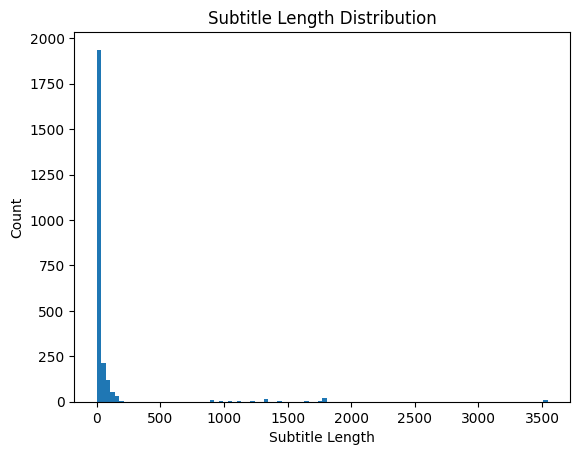

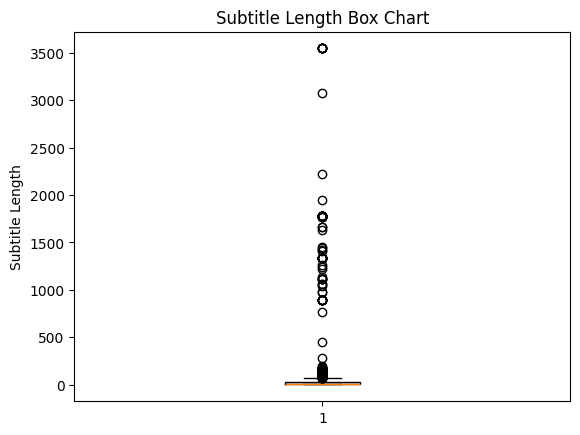

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `reservoir` contains the sampled data
# Extract the 'subtitle' field from each item in the sample
subtitle_len = [len(item['transcript']) for item in data if item['transcript']]

# Convert to numpy array for processing
subtitle_len = np.array(subtitle_len)

# Filter: Remove subtitle length > 200 and <= 0
filtered_subtitle_len = subtitle_len

# Calculate statistics
mean = np.mean(filtered_subtitle_len)
median = np.median(filtered_subtitle_len)
max_len = np.max(filtered_subtitle_len)
min_len = np.min(filtered_subtitle_len)
std = np.std(filtered_subtitle_len)

# Calculate IQR
Q1 = np.percentile(filtered_subtitle_len, 25)
Q3 = np.percentile(filtered_subtitle_len, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)
print(f"Mean: {mean}, Median: {median}, Max Length: {max_len}, Min Length: {min_len}, Std: {std}")
print(f"Q1: {Q1}, Median: {median}, Q3: {Q3}")

# Plot histogram
plt.hist(filtered_subtitle_len, bins=100)
plt.xlabel('Subtitle Length')
plt.ylabel('Count')
plt.title('Subtitle Length Distribution')
plt.show()

# Plot box chart
plt.boxplot(filtered_subtitle_len)
plt.ylabel('Subtitle Length')
plt.title('Subtitle Length Box Chart')
plt.show()


In [8]:
data[0]

{'video_id': 'ILE12hEW5Ck_30.000_40.000',
 'desc': 'In one room, a group of women were dancing disco to dance music.',
 'subtitle': '',
 'transcript': " Just let me know, yeah, oh, she's a brand house. She's the one, the only one, the one."}

In [12]:
import os
import json
import random
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# File paths
input_file = "/Users/zhuzengliang/Downloads/valor3k/valor3k_filtered_with_transcription.json"
output_file_resampled = "/Users/zhuzengliang/Downloads/valor3k/valor3k_resampled.json"
output_dir = "/Users/zhuzengliang/Downloads/valor3k"

# Ensure the output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Load the dataset
with open(input_file, 'r') as f:
    data = json.load(f)

# Ensure the dataset has around 2400 samples
if len(data) < 1700:
    print(f"Warning: Dataset size is {len(data)} instead of >1700.")

# Resample to 1700 samples
resampled_data = random.sample(data, 1700)

# Save the resampled dataset
with open(output_file_resampled, 'w') as f:
    json.dump(resampled_data, f, indent=4)

print(f"Resampled dataset saved to {output_file_resampled}")

# Extract clip_ids and split data into train and test sets
clip_ids = [item['video_id'] for item in resampled_data]
random.shuffle(clip_ids)

# 70-30 split
split_ratio = 0.3
split_index = int(len(clip_ids) * (1 - split_ratio))
train_ids = clip_ids[:split_index]
test_ids = clip_ids[split_index:]

# Save the train and test IDs
train_ids_file = os.path.join(output_dir, "standardsplit_train_id.json")
test_ids_file = os.path.join(output_dir, "standardsplit_test_id.json")

with open(train_ids_file, 'w') as f:
    json.dump(train_ids, f, indent=4)

with open(test_ids_file, 'w') as f:
    json.dump(test_ids, f, indent=4)

print(f"Train IDs saved to {train_ids_file}")
print(f"Test IDs saved to {test_ids_file}")

# Prepare the txt_mapper.json
txt_mapper = {}
for item in resampled_data:
    clip_id = item["video_id"]
    question = item.get("transcript", "").strip()
    if len(question) > 500:
        question = question[:500]
    answer = item.get("desc", "").strip()
    if question and answer:  # Ensure valid entries
        if clip_id not in txt_mapper:
            txt_mapper[clip_id] = []
        txt_mapper[clip_id].append({
            "question": question,
            "answer": answer
        })

# Save txt_mapper.json
txt_mapper_file = os.path.join(output_dir, "txt_mapper.json")
with open(txt_mapper_file, 'w') as f:
    json.dump(txt_mapper, f, indent=4)

print(f"txt_mapper saved to {txt_mapper_file}")

Resampled dataset saved to /Users/zhuzengliang/Downloads/valor3k/valor3k_resampled.json
Train IDs saved to /Users/zhuzengliang/Downloads/valor3k/standardsplit_train_id.json
Test IDs saved to /Users/zhuzengliang/Downloads/valor3k/standardsplit_test_id.json
txt_mapper saved to /Users/zhuzengliang/Downloads/valor3k/txt_mapper.json


In [16]:
import os
import json

# File paths
input_file = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/vast3000_filtered_with_transcripts.json"  # Replace with your actual JSON file path
output_file = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/caption_annotation.json"  # Replace with desired output path

# Load the dataset
with open(input_file, 'r') as f:
    data = json.load(f)

# Prepare the caption annotations
caption_annotations = []
for item in data:
    video_id = item.get('clip_id')
    caption = item.get('vast_cap', '').strip()  # Replace 'vast_cap' with the correct key if different
    if video_id and caption:
        caption_annotations.append({'video_id': video_id, 'caption': caption})

# Save to caption_annotation.json
with open(output_file, 'w') as f:
    json.dump(caption_annotations, f, indent=4)

print(f"Caption annotations saved to {output_file}")

Caption annotations saved to /Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/vast3000/caption_annotation.json


# test set

In [15]:
import os
import json
import random
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# File paths
input_file = "/Users/zhuzengliang/Documents/GitHub/proj-11777/VividScribe/data/mix120/mix120.json"
output_dir = "/Users/zhuzengliang/Downloads/extracted_data-2"

# Ensure the output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Load the dataset
with open(input_file, 'r') as f:
    data = json.load(f)

# Extract clip_ids and split data into train and test sets
clip_ids = [item['video_id'] for item in data]

# 70-30 split
test_ids = clip_ids

test_ids_file = os.path.join(output_dir, "standardsplit_test_id.json")

with open(test_ids_file, 'w') as f:
    json.dump(test_ids, f, indent=4)

print(f"Test IDs saved to {test_ids_file}")

# Prepare the txt_mapper.json
txt_mapper = {}
for item in data:
    clip_id = item["video_id"]
    question = item.get("subtitle", "").strip()
    if len(question) > 500:
        question = question[:500]
    answer = item.get("caption", "").strip()
    if answer:  # Ensure valid entries
        if clip_id not in txt_mapper:
            txt_mapper[clip_id] = []
        txt_mapper[clip_id].append({
            "question": question,
            "answer": answer
        })

# Save txt_mapper.json
txt_mapper_file = os.path.join(output_dir, "txt_mapper.json")
with open(txt_mapper_file, 'w') as f:
    json.dump(txt_mapper, f, indent=4)

print(f"txt_mapper saved to {txt_mapper_file}")

Test IDs saved to /Users/zhuzengliang/Downloads/extracted_data-2/standardsplit_test_id.json
txt_mapper saved to /Users/zhuzengliang/Downloads/extracted_data-2/txt_mapper.json
